# Setup

## TODO

- Explore Feature engineering
- Feature selection

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objs as go
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from xgboost import XGBRegressor
import shap
from tscv import GapKFold, gap_train_test_split
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings("ignore")


os.chdir("C:\\Users\\olive\\OneDrive\\Documents\\Masters work\\capstone_project\\analysis")

# Set seed
seed = 2604

c:\Users\olive\miniconda3\envs\ami\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
money_vars = ['M1SL',
              'M2SL',
              'M2REAL',
              'AMBSL',
              'TOTRESNS',
              'NONBORRES',
              'BUSLOANS',
              'REALLN',
              'NONREVSL',
              'CONSPI',
              'MZMSL',
              'DTCOLNVHFNM',
              'DTCTHFNM',
              'INVEST',
              'M4DIVISIA']

# Import data

In [4]:
df_raw = pd.read_csv("https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv")
df_raw.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9665,23.3891,22.2688,31.7011,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3966,23.7048,22.4617,31.9337,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7193,23.8483,22.5719,31.9337,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.2032,24.1927,22.9026,32.4374,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN


In [5]:
# Read the Divisia file
divisia = pd.read_excel('Divisia.xlsx', sheet_name='Broad', skiprows = 1, usecols=[0, 6]).dropna().rename(columns={'Date': 'sasdate', 'Divisia M4- year-over-year percentage growth rate': 'M4DIVISIA'})
divisia.tail(3)

,sasdate,M4DIVISIA
682,2023-11-01,-0.019228
683,2023-12-01,-0.014020
684,2024-01-01,-0.011351


## Transformations

In [6]:
# Function to apply transformation based on first value
def transform_column(col):
    """
    Function to transform FRED-MD data using the suggested transformations from McCracken & Ng (2015). The dataset indicates the suggested transformation in the first row.
    """

    # No transformation
    if col.iloc[0] == 1:

        # Drop the first row
        col = col.iloc[1:]

        return col
    
    # First difference
    elif col.iloc[0] == 2:

        # Drop the first row
        col = col.iloc[1:]

        return col.diff()
    
    # Second difference
    elif col.iloc[0] == 3:
        
        # Drop the first row
        col = col.iloc[1:]

        return col.diff().diff
    
    # Log 
    elif col.iloc[0] == 4:

        # Drop the first row
        col = col.iloc[1:]

        return np.log(col)

    # Log difference
    elif col.iloc[0] == 5:

        # Drop the first row
        col = col.iloc[1:]

        return np.log(col).diff()
    
    # Log 2nd difference
    elif col.iloc[0] == 6:
        
        # Drop the first row
        col = col.iloc[1:]

        return np.log(col).diff().diff()
    
    # Percentage change
    elif col.iloc[0] == 7:

        # Drop the first row
        col = col.iloc[1:]

        return col.pct_change() * 100
    
    else:
        return col.iloc[1:]

# Replace the value in the first row of column 'CPIAUCSL' with 1
#print(df_raw.iloc[0, df_raw.columns.get_loc('CPIAUCSL')])
df_raw.iloc[0, df_raw.columns.get_loc('CPIAUCSL')] = 1

# Apply transformation to each column and drop NaN rows created
transformed_df = df_raw.apply(transform_column).iloc[2:]  
transformed_df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
3,3/1/1959,0.006457,0.007325,0.009404,-0.003374,0.008321,0.014306,0.006035,0.004894,0.000000,...,-0.001148,0.000292,-0.000022,-0.008147,0.004819,NaN,0.004929,0.004138,-0.014792,NaN
4,4/1/1959,0.006510,0.007029,-0.003622,0.019915,0.000616,0.021075,0.014338,0.014545,0.015650,...,0.001312,0.001760,-0.000022,0.012203,-0.004890,NaN,0.012134,0.006734,0.024929,NaN
5,5/1/1959,0.005796,0.006618,0.012043,0.006839,0.007803,0.014955,0.008270,0.009582,0.004770,...,-0.001695,-0.001867,-0.000021,-0.004090,-0.004819,NaN,0.002828,0.002020,-0.015342,NaN
6,6/1/1959,0.003068,0.003012,0.003642,-0.000097,0.009064,0.001141,0.007034,0.007128,-0.004767,...,0.003334,0.001946,-0.004619,0.003992,0.004796,NaN,0.009726,0.009007,-0.012252,NaN
7,7/1/1959,-0.000580,-0.000762,-0.003386,0.012155,-0.000330,-0.024240,0.001168,0.008249,0.013054,...,-0.001204,-0.000013,0.000000,-0.004040,-0.004796,NaN,-0.004631,-0.001000,0.029341,NaN


## Feature Engineering

In [7]:
# Plotting each column
trans_cols = ['M1SL', 'M2SL', 'M2REAL']
for col in trans_cols:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=transformed_df['sasdate'], y=transformed_df[col], mode='lines'))
    fig.update_layout(
        title=col + " over time",
        xaxis_title="Date",
        yaxis_title=col,
        xaxis=dict(tickangle=-45),
        showlegend=False,
        margin=dict(l=50, r=50, t=50, b=50),
        height=400,
        width=800,
        template="plotly_white"
    )
    fig.show()

The definition of some money variables changed in May 2020. We therefore replace the transformed value to the mean value exluding these dates.

In [8]:
# Replace dates with mean value excluding those rows
dates_to_exclude = ['3/1/2020', '4/1/2020', '5/1/2020', '6/1/2020']
for var in trans_cols:
    mean_value = np.mean(transformed_df.loc[~transformed_df['sasdate'].isin(dates_to_exclude), var])
    transformed_df.loc[transformed_df['sasdate'].isin(dates_to_exclude), var] = mean_value


In [9]:
# Plotting each column
trans_cols = ['M1SL', 'M2SL', 'M2REAL']
for col in trans_cols:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=transformed_df['sasdate'], y=transformed_df[col], mode='lines'))
    fig.update_layout(
        title=col + " - after feature engineering",
        xaxis_title="Date",
        yaxis_title=col,
        xaxis=dict(tickangle=-45),
        showlegend=False,
        margin=dict(l=50, r=50, t=50, b=50),
        height=400,
        width=800,
        template="plotly_white"
    )
    fig.show()

## Merge FRED-MD with Divisia data

Quick check of the Divisia data to look at the trend and for stationarity.

ADF Statistic: -5.117644806305123
p-value: 1.2917794148269648e-05
Divisia data is stationary


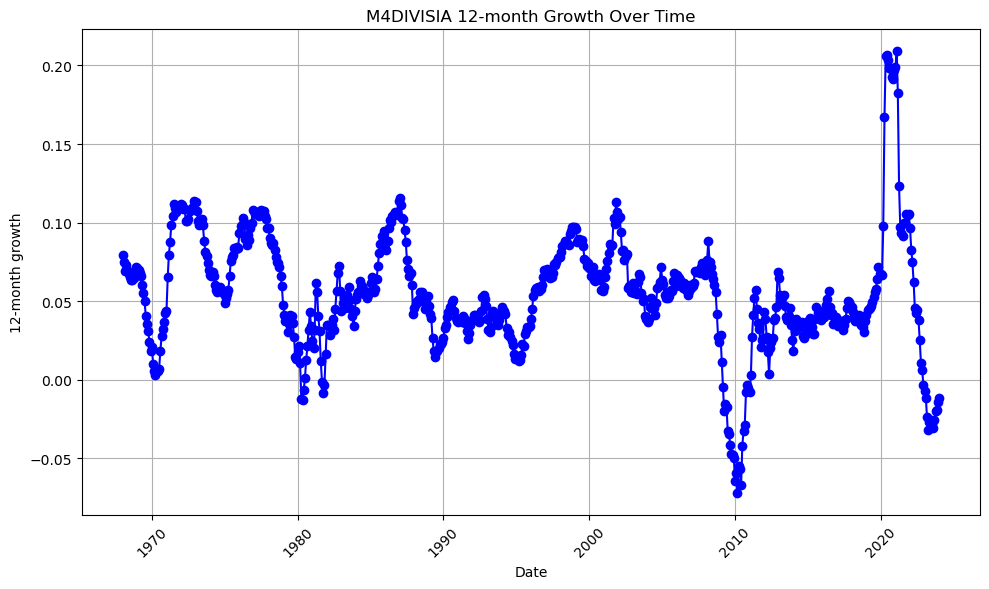

In [10]:
# Plotting divisia
plt.figure(figsize=(10, 6))
plt.plot(divisia['sasdate'], divisia['M4DIVISIA'], color='blue', marker='o', linestyle='-')

# Formatting
plt.title('M4DIVISIA 12-month Growth Over Time')
plt.xlabel('Date')
plt.ylabel('12-month growth')
plt.grid(True)
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()

# Perform Augmented Dickey-Fuller test
result = adfuller(divisia['M4DIVISIA'].dropna())


# Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Check if data is stationary or not based on the p-value
if result[1] < 0.05:
    print('Divisia data is stationary')
else:
    print('Divisia data is not stationary')

In [11]:
# Convert 'sasdate' to datetime with format "%b/%d/%Y"
transformed_df['sasdate'] = pd.to_datetime(transformed_df['sasdate'], format="%m/%d/%Y")
#divisia['sasdate'] = pd.to_datetime(divisia['sasdate'], format="%m/%d/%Y")

# Perform left join
merged_df = pd.merge(transformed_df, divisia, on='sasdate', how='left')

# Set 'sasdate' as index
merged_df.set_index('sasdate', inplace=True)
merged_df.tail()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,M4DIVISIA
sasdate,,,,,,,,,,,,,,,,,,,,,
2023-12-01,0.001759,0.001733,0.004578,0.006499,0.003631,-0.003218,-0.004305,-0.004766,-0.004872,0.010977,...,0.000458,-0.004356,-0.007758,-0.000080,8.4,0.000385,0.000526,0.018189,12.6960,-0.014020
2024-01-01,0.006820,0.002821,-0.002984,-0.012851,-0.010902,-0.007590,-0.005843,-0.005964,-0.003560,-0.023857,...,0.003687,-0.000355,0.008535,-0.005941,9.3,-0.001394,-0.000015,-0.009794,13.3453,-0.011351
2024-02-01,-0.000532,-0.002057,0.003205,0.002981,0.007002,0.008150,0.007054,0.003656,-0.000202,0.020139,...,-0.004090,-0.001653,-0.011091,0.002188,-2.1,-0.000892,-0.001789,-0.005141,13.8808,NaN
2024-03-01,0.001947,0.001451,0.004066,-0.000843,0.006457,0.001212,0.003315,0.003970,0.005064,0.016705,...,0.001669,0.001288,0.006799,-0.001482,2.5,0.001680,0.001862,0.019568,13.7658,NaN
2024-04-01,0.000180,0.000032,-0.000541,NaN,0.000174,0.000059,-0.000820,-0.000371,0.001017,-0.014723,...,-0.001569,-0.002609,-0.002838,-0.000376,-2.2,NaN,NaN,-0.029344,16.4023,NaN


# Data cleaning

In [12]:
# Data shape
print(f' The data has {merged_df.shape[1]} columns and {merged_df.shape[0]} rows.')

 The data has 127 columns and 782 rows.


In [13]:
# Check for missing values
missing_val_count = merged_df.isnull().sum().sum() # the 2nd sum provides the value for the entire dataframe (rather than each column)
print(f'There are {missing_val_count} missing values in the df dataframe, which constitutes {np.round(missing_val_count/(merged_df.shape[1]*merged_df.shape[0])*100, 2)}% of the dateframe.')

There are 1114 missing values in the df dataframe, which constitutes 1.12% of the dateframe.


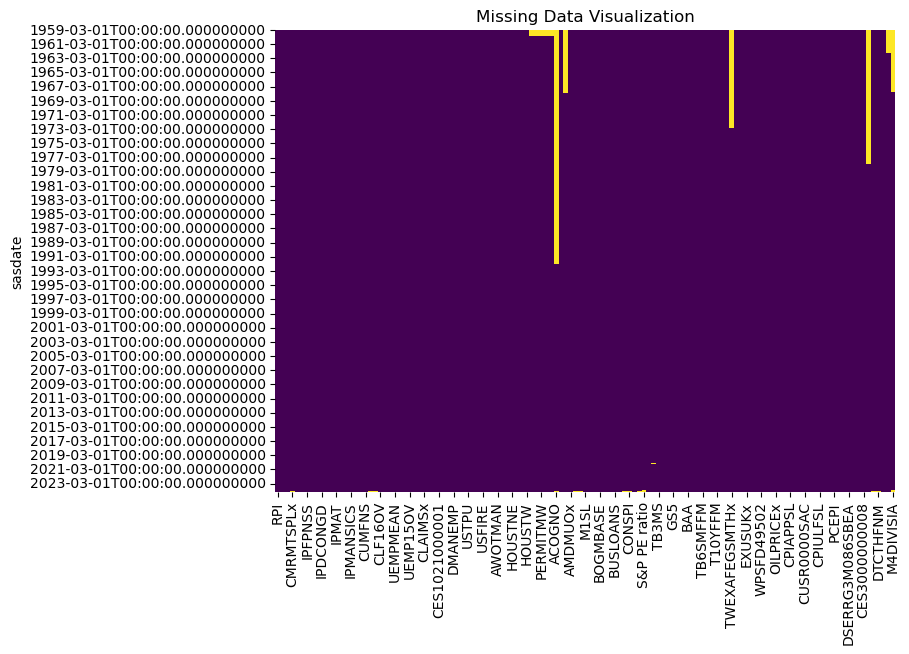

Variables with missing data:
ACOGNO           397
UMCSENTx         227
TWEXAFEGSMTHx    167
M4DIVISIA        109
ANDENOx          108
VIXCLSx           40
PERMIT            10
PERMITNE          10
PERMITMW          10
PERMITS           10
PERMITW           10
S&P PE ratio       3
CP3Mx              2
DTCTHFNM           1
DTCOLNVHFNM        1
COMPAPFFx          1
CMRMTSPLx          1
S&P div yield      1
CONSPI             1
HWI                1
ISRATIOx           1
BUSINVx            1
HWIURATIO          1
NONREVSL           1
dtype: int64
Dropped columns:
Index(['ACOGNO', 'UMCSENTx', 'TWEXAFEGSMTHx'], dtype='object')


In [14]:
# Plot missing data
fig = plt.figure(figsize=(8, 6))
sns.heatmap(merged_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Data Visualization')
plt.show()

# Get the count of missing values for each column
missing_values = merged_df.isnull().sum()

# Filter columns with missing values
missing_variables = missing_values[missing_values > 0].sort_values(ascending=False)

print("Variables with missing data:")
print(missing_variables)

# Drop columns with more than 10 missing values
columns_to_drop = missing_variables[missing_variables > 150].index
merged_df.drop(columns=columns_to_drop, inplace=True)

# Print dropped columns
print("Dropped columns:")
print(columns_to_drop)


## Summary Statistics

In [15]:
sum_stat = merged_df.describe().drop(['25%', '75%'], axis = 0)
sum_stat

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,M4DIVISIA
count,782.000000,782.000000,782.000000,781.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,...,782.000000,782.000000,782.000000,782.000000,782.000000,781.000000,781.000000,782.000000,742.000000,673.000000
mean,0.002570,0.002396,0.002611,0.002162,0.004665,0.001948,0.001856,0.001927,0.001487,0.002217,...,0.000005,0.000002,-0.000004,-0.000003,-0.000002,0.000010,0.000004,-0.000002,19.331013,0.055062
std,0.011783,0.006172,0.007980,0.012588,0.015554,0.010003,0.009657,0.010589,0.010637,0.033419,...,0.006138,0.001593,0.003992,0.008929,0.004754,0.025432,0.022704,0.010887,7.091525,0.038015
min,-0.144164,-0.062363,-0.116124,-0.127328,-0.156901,-0.143656,-0.146569,-0.157030,-0.124075,-0.496683,...,-0.037352,-0.009434,-0.029509,-0.068074,-0.026868,-0.195565,-0.259562,-0.084681,9.484400,-0.071879
50%,0.002655,0.002782,0.002543,0.002297,0.004841,0.002450,0.002268,0.002106,0.001662,0.002968,...,0.000055,-0.000030,-0.000012,-0.000017,-0.000010,0.000548,0.000561,0.000412,17.635800,0.054054
max,0.184074,0.040169,0.079478,0.078878,0.172072,0.062986,0.068703,0.082872,0.085326,0.356637,...,0.027667,0.015965,0.019303,0.053050,0.024828,0.188590,0.258050,0.049963,62.964800,0.208937


<Axes: >

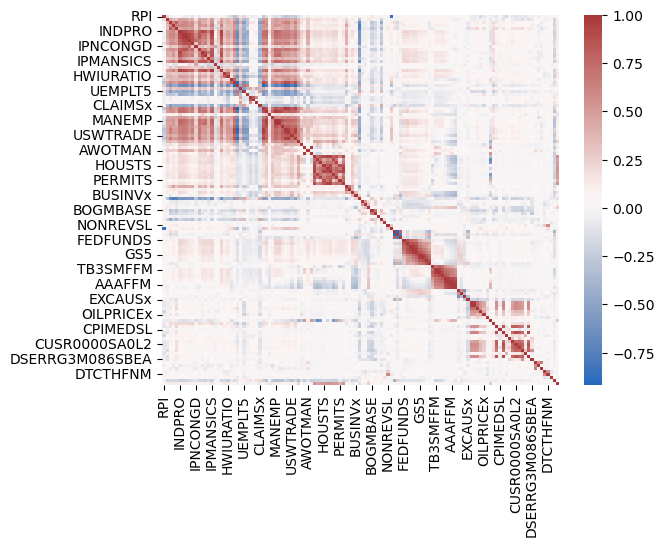

In [16]:
# Plot a correlation matrix
correlation = merged_df.corr()
sns.heatmap(correlation, cmap='vlag') # set the mid-point to zero , center=0

## Set dependent variable and drop missing values

In [17]:
# Calc 12-month growth
merged_df['CPIAUCSL_12M_Growth'] = merged_df['CPIAUCSL'].pct_change(periods=12) * 100

# Set target var
dep_var ='CPIAUCSL_12M_Growth'
forecast_range = 12
merged_df['target_var'] = merged_df[dep_var].shift(-forecast_range)

# DROP MISSING VALUES
merged_df_no_na = merged_df.dropna()

# Set y
y = merged_df_no_na['target_var']
y


sasdate
1968-03-01    5.247813
1968-04-01    5.523256
1968-05-01    5.507246
1968-06-01    5.475504
1968-07-01    5.444126
                ...   
2022-12-01    3.323160
2023-01-01    3.105981
2023-02-01    3.165743
2023-03-01    3.475131
2023-04-01    3.357731
Name: target_var, Length: 660, dtype: float64

# Principle Component Analysis

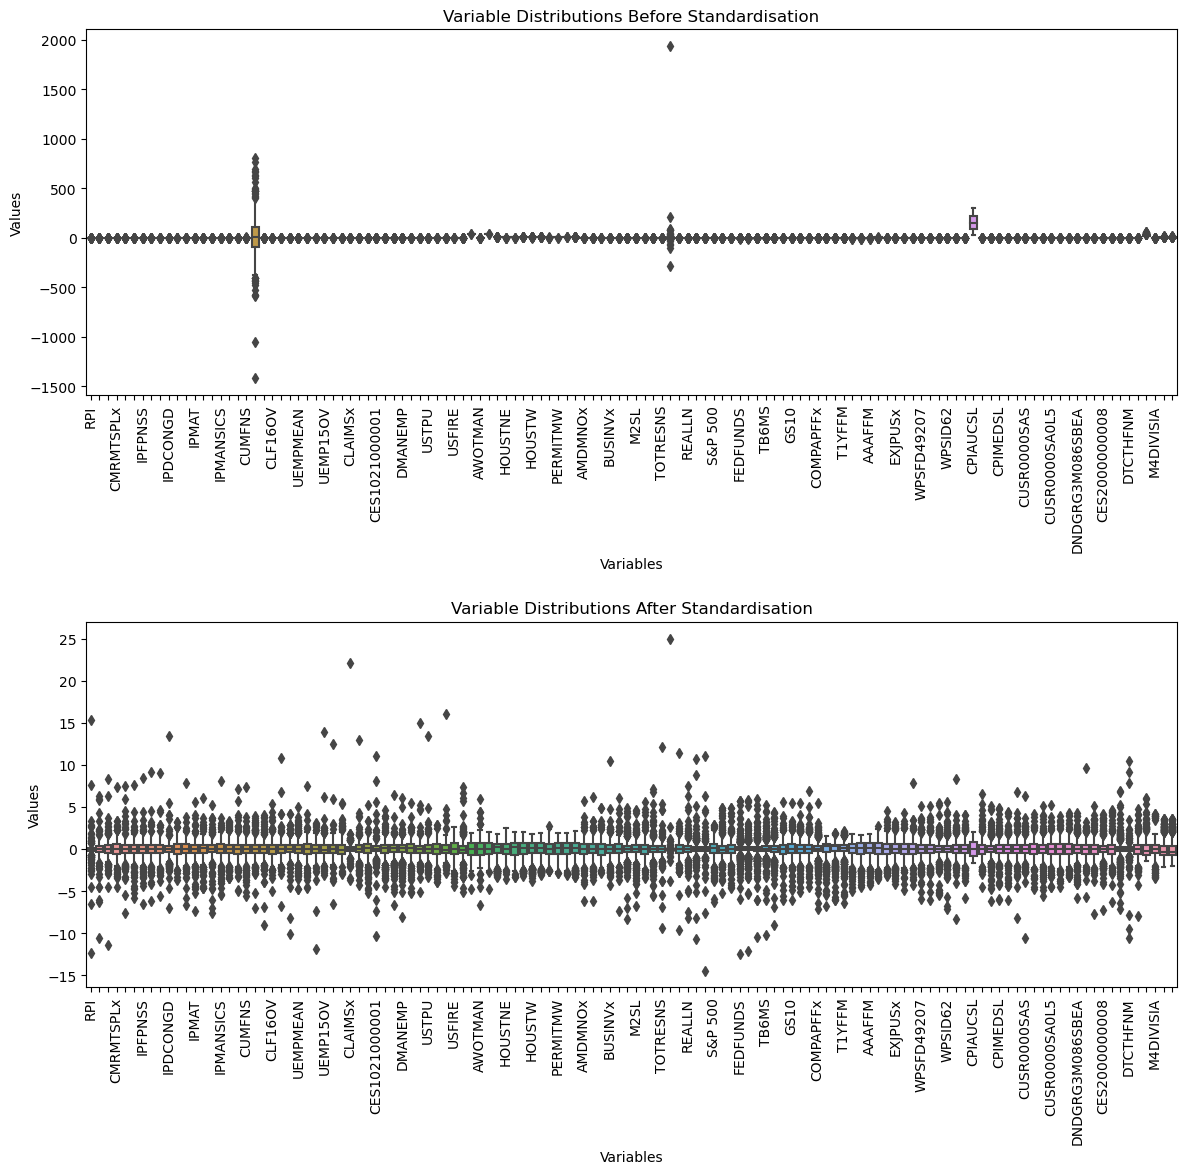

In [18]:

# Standardise the features to put them over a common unit
standard = StandardScaler()
standard.fit(merged_df_no_na)
features_standard = standard.transform(merged_df_no_na)
features_standard_df = pd.DataFrame(features_standard, columns=merged_df_no_na.columns, index=merged_df_no_na.index)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot variable distributions before standardization in the first subplot
sns.boxplot(data=merged_df_no_na, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)  # Rotate x-axis labels for readability
axes[0].set_xlabel('Variables')
axes[0].set_ylabel('Values')
axes[0].set_title('Variable Distributions Before Standardisation')

# Plot variable distributions after standardization in the second subplot
sns.boxplot(data=features_standard_df, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)  # Rotate x-axis labels for readability
axes[1].set_xlabel('Variables')
axes[1].set_ylabel('Values')
axes[1].set_title('Variable Distributions After Standardisation')

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show every tenth label on the x-axis
for ax in axes:
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        if i % 3 != 0:
            label.set_visible(False)

# Show the combined plot
plt.savefig('boxplot.png')
plt.show()

In [19]:
# Find the variable with the highest value in each row
max_variable = merged_df_no_na.idxmax(axis=1)

print("Variable with the highest value in each row:")
print(max_variable)

Variable with the highest value in each row:
sasdate
1968-03-01         HWI
1968-04-01         HWI
1968-05-01      AWHMAN
1968-06-01      AWHMAN
1968-07-01         HWI
                ...   
2022-12-01    CPIAUCSL
2023-01-01    CPIAUCSL
2023-02-01    CPIAUCSL
2023-03-01    CPIAUCSL
2023-04-01    CPIAUCSL
Length: 660, dtype: object


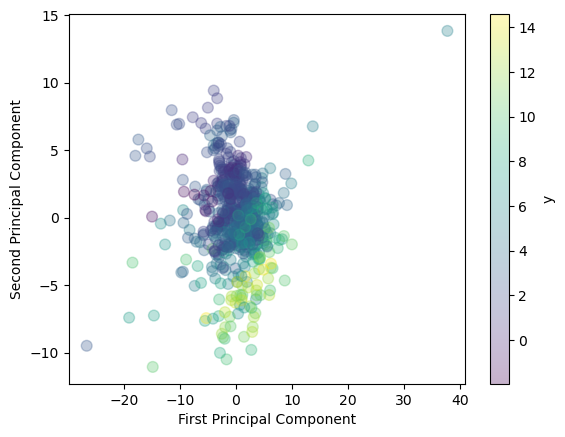

In [20]:
## Fit PCA to 95%
pca = PCA(n_components= 10) 
pca.fit(features_standard_df)

# Transform the data using the fitted model
pca_output = pca.transform(features_standard_df)

# Visualise the shape of the output
pca_output.shape

# Plot the first 2 principal components
plt.scatter(pca_output[:,0], pca_output[:,1], s=60, c = y.values, alpha = 0.3)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='y')
plt.show()


In [21]:
# Plot a 3d chart with PCAs on each axis
fig = plt.figure(figsize=(15, 8))
fig = px.scatter_3d(x=pca_output[:,0], y=pca_output[:,1], z=pca_output[:,2], color=y.values,  opacity=0.2)

# Format chart
fig.update_layout(scene = dict(
                    xaxis_title=r'PCA 1',
                    yaxis_title=r'PCA 2',
                    zaxis_title=r'PCA 3'),
                    width=700,
                    margin=dict(r=0, b=0, l=0, t=0),
                    coloraxis_colorbar=dict(title='y'))
fig.show()

<Figure size 1500x800 with 0 Axes>

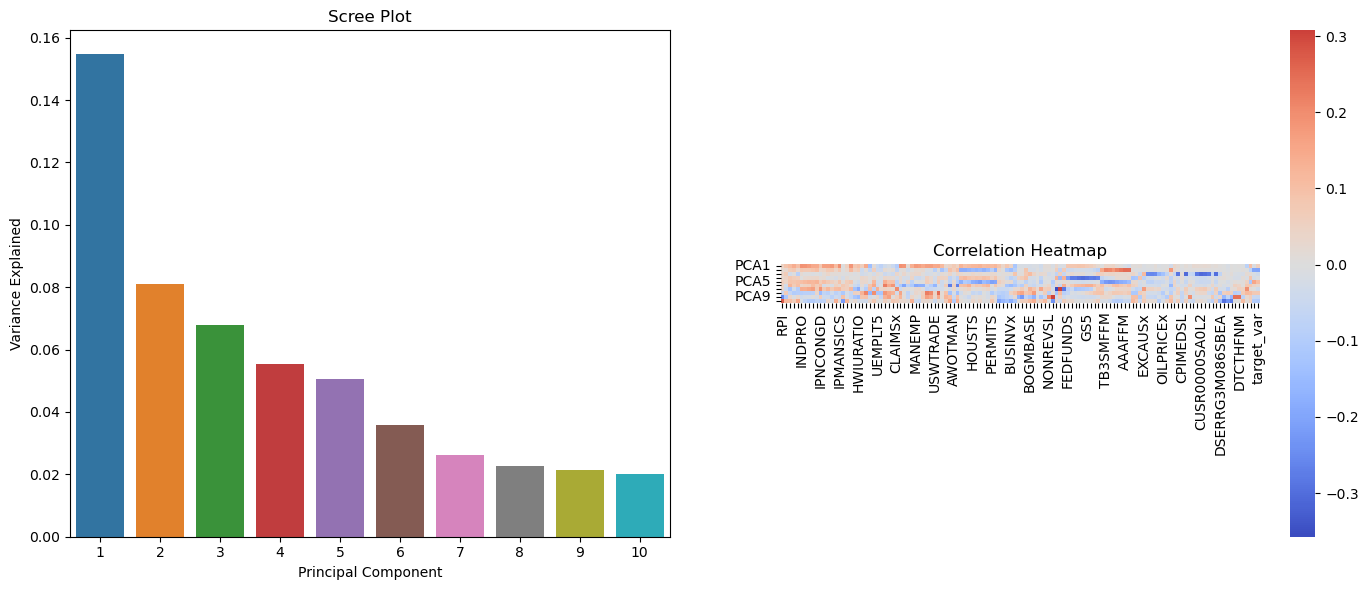

In [22]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the Scree Plot in the first subplot
PC_values = np.arange(pca.n_components_) + 1
sns.barplot(x=PC_values, y=pca.explained_variance_ratio_, ax=axes[0])
axes[0].set_title('Scree Plot')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')

# Plot the heatmap in the second subplot
ax = sns.heatmap(pca.components_,
                cmap='coolwarm',
                yticklabels=["PCA" + str(x) for x in range(1, pca.n_components_ + 1)],
                xticklabels=list(merged_df_no_na.columns),
                cbar_kws={"orientation": "vertical"},
                center=0, ax=axes[1])
ax.set_aspect("equal")

# Rotate the y-axis tick labels for the heatmap
plt.setp(ax.get_yticklabels(), rotation=0)  # Adjust the rotation angle as needed

axes[1].set_title('Correlation Heatmap')

# Adjust the layout to prevent overlapping titles and make the left plot smaller
plt.tight_layout(w_pad=4)

# Show every X label on the x-axis
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    if i % 5 != 0:
        label.set_visible(False)

# Show every Y label on the y-axis
labels = ax.get_yticklabels()
for i, label in enumerate(labels):
    if i % 4 != 0:
        label.set_visible(False)

# Show the combined plot
plt.savefig('pca_results.png')
plt.show()

### Money data exploration

<Axes: >

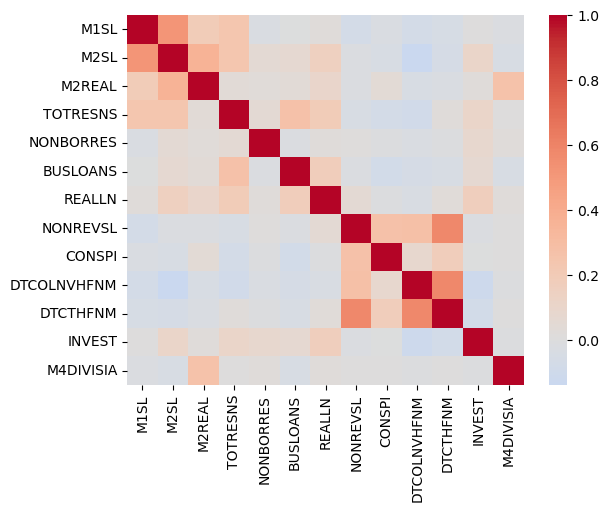

In [23]:
# Filter to keep money variables
money_df = merged_df.filter([col for col in merged_df.columns if col in money_vars])
money_df

# Plot a correlation matrix
money_correlation = money_df.corr()
sns.heatmap(money_correlation, cmap='coolwarm', center=0) # set the mid-point to zero 

In [24]:
corr_money = correlation.filter([col for col in merged_df.columns if col in money_vars])
corr_money.sort_values(by = 'M4DIVISIA', ascending=False).head(20)

,M1SL,M2SL,M2REAL,TOTRESNS,NONBORRES,BUSLOANS,REALLN,NONREVSL,CONSPI,DTCOLNVHFNM,DTCTHFNM,INVEST,M4DIVISIA
M4DIVISIA,-0.016741,-0.039117,0.262621,0.005338,0.024396,-0.044036,0.023939,0.007551,0.007386,-0.005193,0.005362,-0.010481,1.000000
HOUST,-0.008630,-0.017568,-0.019498,0.019934,-0.034798,0.028367,0.029420,0.016170,0.032625,-0.014159,-0.002119,-0.018122,0.556569
PERMIT,-0.009068,-0.026348,-0.022952,0.016465,-0.037572,0.035908,0.029751,0.016136,0.051485,0.002791,0.007703,-0.015243,0.545856
PERMITW,-0.007327,-0.013678,-0.012847,0.011647,-0.039141,0.034836,0.024219,0.019771,0.044368,0.011818,0.020390,-0.022110,0.544233
HOUSTW,-0.004802,-0.009844,-0.018445,-0.002593,-0.036509,0.019170,0.024943,0.012406,0.059783,-0.000896,0.006070,-0.001578,0.533270
PERMITMW,-0.010516,-0.019369,-0.020640,0.016822,-0.056990,0.015810,0.023526,0.013072,0.017049,-0.001967,0.004681,-0.012154,0.516467
PERMITNE,-0.003740,-0.019051,0.046212,-0.000027,-0.041482,0.013372,0.014356,0.005553,0.054645,-0.002355,-0.001078,-0.007298,0.497221
HOUSTS,-0.020583,-0.027054,-0.034357,0.016912,-0.014418,0.039035,0.029943,0.026464,0.034468,-0.016047,-0.001097,-0.023621,0.494606
HOUSTMW,0.002043,-0.008107,-0.027884,0.038910,-0.051383,0.012139,0.021587,0.012844,-0.013661,-0.015505,-0.012390,-0.020444,0.489013
HOUSTNE,0.020466,0.003400,0.050886,0.024381,-0.026498,-0.003192,0.023186,-0.008093,0.019229,-0.003881,0.011695,-0.001708,0.446583


The Divisia measure is highly correlated with housing variables: housing stats and new private housing permits.

M2 Real is correlated with real exonomy variables such as unemployment (31%), corporate bond spreads (29%) and Treasury spreads (23%).

<Axes: >

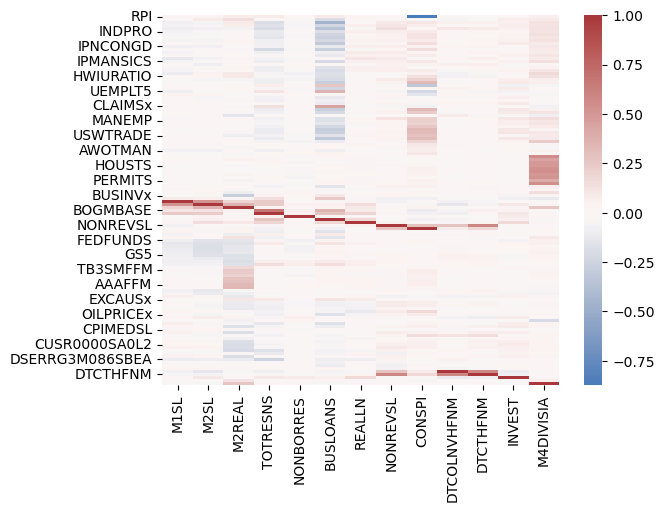

In [25]:
sns.heatmap(corr_money, cmap='vlag', center=0) # set the mid-point to zero 

# Analysis

## Analysis Set-up

### Functions

In [26]:
def add_lagged_features(X, lag_counts, target_lag):
    """
    Add lagged features to the DataFrame X based on the lag counts provided.

    Parameters:
        X (DataFrame): The feature matrix.
        lag_counts (list of int): List of integers determining the number of lags created for each feature in X.

    Returns:
        DataFrame: X with added lagged features.
    """
    X_lagged = X.copy()

    # Loop through each variable in expert_vars
    for var in X_lagged:
        # Loop through each lag month
        for lag in lag_counts:
            # Create new column names
            col_name = f"{var}_{lag}M_lag"
            
            # Shift the variable values by the specified number of months
            X_lagged[col_name] = X_lagged[var].shift(lag)
    

    # Create target_var lags
    for lag in target_lag:
        if lag not in lag_counts:
            col_name = f"{dep_var}_{lag}M_lag"

            # Shift the variable values by the specified number of months
            X_lagged[col_name] = X_lagged[dep_var].shift(lag)

    # Drop rows with NaNs introduced by shifting
    X_lagged.dropna(inplace=True)

    return X_lagged


def prepare_data(X, y, lag_counts=None, test_size=0.2, gap_size=2, target_lag = None):
    """
    Prepare the data for modeling by creating train-test splits, scaling features, and adding lagged features.

    Parameters:
        X (DataFrame): The feature matrix.
        y (Series): The target variable.
        test_size (float): The proportion of the dataset to include in the test split.
        gap_size (int): The gap size between train and test sets for time series splitting.
        lag_counts (list of int): Optional. List of integers determining the number of lags created for each feature in X.

    Returns:
        tuple: A tuple containing:
            - X_train_scaled (array-like): Scaled features of the training set.
            - X_test_scaled (array-like): Scaled features of the test set.
            - y_train (array-like): Target variable of the training set.
            - y_test (array-like): Target variable of the test set.
    """
    # If no lags are added, dont filter the y array
    max_lag = 0

    if lag_counts is not None:

        # If lags are added, we need to filter the y array
        max_lag = max(max(lag_counts), max(target_lag))

        # Adding lagged features
        X_lagged = add_lagged_features(X, lag_counts, target_lag)
    
    # Create train-test split with most recent observations as test observations
    X_train, X_test, y_train, y_test = gap_train_test_split(X_lagged, y[max_lag:], test_size=test_size, gap_size=gap_size)
    print(f'The training dataset spans {min(X_train.index)} to {max(X_train.index)}\nThe testing dataset spans {min(X_test.index)} to {max(X_test.index)}')

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Scale features
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns, index=X_test.index)

    return X_train_scaled, X_test_scaled, y_train, y_test


# def create_lstm_model(n_steps, n_features, units=25, activation='relu', optimizer='adam'):
#     model = Sequential()
#     model.add(LSTM(units, activation=activation, input_shape=(n_steps, n_features)))
#     model.add(Dense(1))
#     model.compile(optimizer=optimizer, loss='mse')
#     return model

def fit_models_and_evaluate(models, X_train_scaled, X_test_scaled, y_train, y_test, cv, seed):
    """
    Fits the models, performs hyperparameter tuning, makes predictions,
    calculates performance metrics, and computes SHAP values.

    Parameters:
        models (list of dict): List containing dictionaries, where each dictionary contains
            information about the model, including its name, model object, and parameter grid for tuning.
        X_train_scaled (array-like): Scaled features of the training set.
        X_test_scaled (array-like): Scaled features of the test set.
        y_train (array-like): Target variable of the training set.
        y_test (array-like): Target variable of the test set.
        cv (object): Cross-validation object.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: A tuple containing:
            - pred_results (dict): Dictionary containing predictions for each model.
            - performance_table (DataFrame): DataFrame containing performance metrics for each model.
            - explainer (dict): Dictionary containing SHAP explainer objects for each model.
    """
        
    pred_results = pd.DataFrame(y_test)  # To store predictions for each model
    performance_table = pd.DataFrame(columns=["Model", "RMSE", "MAE"])  # To store performance metrics
    explainer = {}  # To store SHAP explainer objects

    #------------------
    # SKLEARN MODELS
    # -----------------

    for model_info in models:
        model_name = model_info['name']
        model = model_info['model']
        param_grid = model_info['param_grid']

        # Perform hyperparameter tuning using RandomizedSearchCV
        grid_search = RandomizedSearchCV(model, param_grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=seed)
        grid_search.fit(X_train_scaled, y_train)

        # Get the best model with tuned hyperparameters
        best_model = grid_search.best_estimator_

        # Print the hyperparameters
        print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")

        # Make predictions
        y_pred = best_model.predict(X_test_scaled)

        # Add rescaled test forecast results to dataframe
        pred_results[model_info['name']] = y_pred

        # Calculate performance metrics on the test set
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)

        # Create a DataFrame for the current model's results
        model_results = pd.DataFrame({"Model": [model_name], "RMSE": [rmse], "MAE": [mae]})

        # Concatenate the results with the performance_table
        performance_table = pd.concat([performance_table, model_results], ignore_index=True)

        # Compute SHAP values
        explainer[model_name] = shap.explainers.Permutation(best_model.predict, X_train_scaled) #.shap_values(X_test_scaled)
        #shap_values = explainer.shap_values(X_test_scaled)


    #--------------------------
    #   LSTM
    #--------------------------
    
    n_features = X_train_scaled.shape[1]
    n_steps = 1

    # Reshape data for LSTM
    X_train_lstm = X_train_scaled.to_numpy().reshape((len(X_train_scaled), n_steps, n_features))
    X_test_lstm = X_test_scaled.to_numpy().reshape((len(X_test_scaled), n_steps, n_features))


    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units = 25, activation='relu', input_shape=(n_steps, n_features))) # "relu"
    model.add(Dense(1))  # Output layer with 1 neuron for regression
    model.compile(optimizer='adam', loss='mse')  # Compile the model # 

    # Fit the model
    model.fit(x=X_train_lstm, y=y_train, epochs=50, batch_size=32, verbose=1)

    # Make predictions
    y_pred = model.predict(X_test_lstm)

    # Compute SHAP values
    explainer['LSTM'] = shap.explainers.Permutation(model.predict, X_train_lstm)

    # Evaluate model
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    # Create a DataFrame for the current model's results
    model_results = pd.DataFrame({"Model": 'LSTM', "RMSE": [rmse], "MAE": [mae]})
    
    # Concatenate the results with the performance_table
    performance_table = pd.concat([performance_table, model_results], ignore_index=True)

    # Concatenate the results with the PRED_RESULTS
    pred_results['LSTM'] = y_pred

    # -----------------
    # AR(1)
    # ----------------
        
    # Create DataFrame for training data
    y_train_df = pd.DataFrame(y_train)
    
    # Shift target variable by lag_months
    y_train_df['dep_var'] =  X_train_scaled[dep_var]
    print(y_train_df)

    # Drop NaN values
    y_train_df.dropna(inplace=True)
    
    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(y_train_df['dep_var'].values.reshape(-1,1), y_train_df['target_var'].values.reshape(-1,1))

    # Predict using the model
    y_pred = model.predict(X_test_scaled[dep_var].values.reshape(-1,1)) 
        
    # Calculate evaluation metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Create a DataFrame for the current model's results
    model_results = pd.DataFrame({"Model": 'AR(1)', "RMSE": [rmse], "MAE": [mae]})
    
    # Concatenate the results with the performance_table
    performance_table = pd.concat([performance_table, model_results], ignore_index=True)

    # Concatenate the results with the performance_table
    pred_results['AR(1)'] = y_pred

    # Moving the 'target_var' column for visualisation colours
    target_var_col = pred_results.pop('target_var') # Removing 'target_var' column and storing it
    pred_results['target_var'] = target_var_col # Adding 'target_var' column to the end


    return pred_results, performance_table, explainer

def create_visualizations(pred_results, performance_table, title=None):
    """
    Creates interactive line and bar charts using Plotly Express.

    Parameters:
        pred_results (DataFrame): DataFrame containing model predictions.
        performance_table (DataFrame): DataFrame containing performance metrics for each model.
        title (str): Title for the charts.

    Returns:
        None
    """
    # Create an interactive line chart
    fig_line = px.line(pred_results, x=pred_results.index.shift(12, freq='M'), y=pred_results.columns, # adjust index to match forecast date
                       labels={'index': 'Date', 'value': 'Value'}, 
                       color_discrete_map={col: px.colors.qualitative.Plotly[i % 10] for i, col in enumerate(pred_results.columns)})
    
    # Set title for the line chart
    if title:
        fig_line.update_layout(title=title + " - Forecast Output")

    # Customize the appearance of the lines
    fig_line.update_traces(line=dict(width=1.5))  # Adjust line width

    # Update x-axis label to "Date"
    fig_line.update_layout(xaxis_title='Date')

    # Rename the trace "target_var" to "Target Variable" in the legend
    fig_line.for_each_trace(lambda trace: trace.update(name='Target Variable') if trace.name == 'target_var' else ())


    # Show the interactive line plot
    fig_line.show()

    # Reshape data for the bar chart
    results_df_melt = pd.melt(performance_table, id_vars=['Model'])

    # Plot bar chart
    fig_bar = px.bar(results_df_melt, x="variable", y="value",
                     color='Model', barmode='group', color_discrete_map={model: px.colors.qualitative.Plotly[i % 10] for i, model in enumerate(performance_table['Model'].unique())})
    
    # Add data labels above each bar
    fig_bar.update_traces(texttemplate='%{y:.2f}', textposition='outside')

    # Update x-axis label to "Date"
    fig_bar.update_layout(xaxis_title='Evaluation Metric', yaxis_title='')

    # Set title for the bar chart
    if title:
        fig_bar.update_layout(title=title + " - Model Evaluation")
    
    fig_bar.show()


### Hyperparameter grid

In [27]:
models = [
    {
        'name': 'MLPRegressor',
        'model': MLPRegressor(),
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (100, 100)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'learning_rate_init': [0.001, 0.01, 0.1],
            'solver': ['adam', 'lbfgs']
        }
    },
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [20, 50, 100, 200],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    },
    {
        'name': 'XGBRegressor',
        'model': XGBRegressor(),
        'param_grid': {
            'n_estimators': [10, 25, 50, 100],
            'max_depth': [3, 5, 10, 20],
            'learning_rate': [0.001, 0.01, 0.1, 0.2],
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9],
            'reg_alpha': [0, 0.1, 0.5],
            'reg_lambda': [0, 0.1, 0.5]
        }
    }
]


## All variables

In [28]:
# Define features and target
X = merged_df_no_na.drop(columns=['target_var']) 
X


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,M4DIVISIA,CPIAUCSL_12M_Growth
sasdate,,,,,,,,,,,,,,,,,,,,,
1968-03-01,0.008502,0.004880,0.016611,0.007415,0.023828,0.003117,0.002617,0.003149,0.005922,-0.002135,...,-0.000418,0.003317,0.026213,0.003515,0.005424,0.002675,-0.000728,19.5470,0.069165,3.939394
1968-04-01,0.004463,0.003041,-0.003711,-0.001986,-0.002282,0.001445,-0.002547,-0.005032,-0.001685,0.000940,...,-0.000964,-0.000044,-0.010506,-0.003552,0.004455,0.003821,-0.013371,19.5401,0.073191,3.927492
1968-05-01,0.005236,0.006109,0.006888,0.006984,0.006385,0.011156,0.008553,0.009289,0.005338,0.012596,...,0.000538,-0.000044,0.007735,0.003478,0.001237,0.000554,0.011764,13.1569,0.069348,4.229607
1968-06-01,0.004600,0.004839,0.008522,0.007046,0.016245,0.003667,0.003376,0.003793,0.006132,0.009683,...,0.000375,-0.006579,-0.010336,-0.003515,0.007064,0.007907,-0.011203,15.3260,0.067229,4.204204
1968-07-01,0.006089,0.006070,0.009261,0.009497,0.012483,-0.001535,-0.003231,-0.004082,-0.002401,-0.008625,...,-0.001031,0.006536,0.010230,-0.000012,0.001026,-0.002510,0.012728,17.1222,0.065634,4.491018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,-0.000062,-0.000201,0.000780,0.014601,-0.010355,-0.015506,-0.012025,-0.008470,-0.006238,-0.010318,...,0.001220,0.001372,0.002095,-0.002378,-0.003058,-0.000990,0.009186,21.7702,-0.003518,6.411498
2023-01-01,0.003915,0.006078,0.010230,0.000566,0.039830,0.010420,0.003975,0.000794,-0.002300,0.007551,...,0.000051,0.001002,0.000266,0.002305,0.000985,0.001142,-0.001625,20.2269,-0.006960,6.362123
2023-02-01,0.002303,0.002134,0.000520,-0.002389,-0.010711,0.000188,-0.001883,-0.001732,0.000258,0.000009,...,-0.001834,-0.005552,-0.002417,-0.007372,-0.002299,-0.000716,-0.001096,20.2141,-0.011435,5.965523


In [29]:
# Run data preperation function with all features
lag_months = [1, 3, 12]  
target_lag = [1, 2, 3, 6, 12]
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(X, y, lag_months, target_lag=target_lag, test_size=0.2)

# Create a Gap K Fold cross-validation object to handle time series
cv = GapKFold(n_splits=10, gap_before=1, gap_after=1) # (see: http://www.zhengwenjie.net/tscv/)

The training dataset spans 1969-03-01 00:00:00 to 2012-03-01 00:00:00
The testing dataset spans 2012-06-01 00:00:00 to 2023-04-01 00:00:00


In [78]:
X_test_scaled

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,VIXCLSx_3M_lag,VIXCLSx_12M_lag,M4DIVISIA_1M_lag,M4DIVISIA_3M_lag,M4DIVISIA_12M_lag,CPIAUCSL_12M_Growth_1M_lag,CPIAUCSL_12M_Growth_3M_lag,CPIAUCSL_12M_Growth_12M_lag,CPIAUCSL_12M_Growth_2M_lag,CPIAUCSL_12M_Growth_6M_lag
sasdate,,,,,,,,,,,,,,,,,,,,,
2012-06-01,-0.517653,-0.617968,-0.680901,-0.495112,-1.164432,-0.219692,-0.108940,-0.016327,-0.443327,0.009323,...,-0.640500,-0.124984,-1.531594,-0.830989,0.025764,-0.922199,-0.639686,-0.334628,-0.742966,-0.480468
2012-07-01,-1.600790,-1.713520,-0.080075,-0.024149,-0.036834,0.030087,-0.499717,-0.464531,-0.115221,-0.231947,...,-0.367100,-0.163666,-1.044000,-1.132990,-0.317856,-0.950568,-0.744246,-0.308416,-0.923617,-0.498470
2012-08-01,-0.838205,-0.684244,-0.441424,-0.304383,0.580905,-0.753833,-0.421116,-0.426089,-0.717694,-0.551333,...,0.083503,2.171321,-0.930026,-1.535041,-0.587308,-1.030324,-0.924939,-0.249238,-0.951993,-0.535821
2012-09-01,0.909037,1.082840,-0.211194,-0.063861,0.230421,-0.325468,-0.657662,-0.630567,-0.466350,-0.663076,...,0.070824,2.328615,-0.863559,-1.047472,-0.710884,-0.939748,-0.953322,-0.229764,-1.031771,-0.642315
2012-10-01,0.770222,1.185731,-0.493581,-0.603608,-0.399605,0.176084,-0.530402,-0.552990,-0.136464,0.450832,...,-0.435728,1.720309,-0.517698,-0.933504,-1.055469,-0.850738,-1.033118,-0.327886,-0.941171,-0.746920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,-0.448550,-0.439024,-0.331371,1.250648,-1.275078,-2.269583,-1.879520,-1.293909,-0.877738,-0.566789,...,0.898800,0.131007,-1.453374,-0.896525,1.478910,0.893721,1.256097,0.907052,1.106266,1.521607
2023-01-01,0.267314,0.696376,1.474863,-0.158142,2.888471,1.133954,0.308884,-0.126924,-0.412916,0.281355,...,1.287546,0.354953,-1.748729,-1.331276,1.203230,0.654827,1.105414,1.039925,0.892789,1.339248
2023-02-01,-0.022855,-0.016817,-0.381070,-0.454783,-1.304611,-0.209260,-0.492266,-0.445116,-0.110940,-0.076605,...,0.341807,0.802431,-1.851013,-1.456825,0.798340,0.638166,0.891887,1.168056,0.653831,1.261223


In [29]:
# Fit models
pred_results, performance_table, explainer = fit_models_and_evaluate(models, X_train_scaled, X_test_scaled, y_train, y_test, cv, seed)
performance_table 

Best hyperparameters for MLPRegressor: {'solver': 'lbfgs', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 100), 'alpha': 0.0001, 'activation': 'relu'}
Best hyperparameters for RandomForestRegressor: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
Best hyperparameters for XGBRegressor: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Epoch 1/50
17/17 [==============================] - 3s 8ms/step - loss: 26.8041
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 16.2481
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 7.8314
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 5.1117
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 4.1147
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 3.2888
Epoch 7/50
17/17 [===========

,Model,RMSE,MAE
0,MLPRegressor,1.780365,1.305647
1,RandomForestRegressor,1.922412,1.558326
2,XGBRegressor,2.248364,1.345409
3,LSTM,2.091119,1.524131
4,AR(1),2.052367,1.507365


# Prediction results

In [59]:
create_visualizations(pred_results, performance_table, title = 'All variables')

# The role of money

In [31]:
# Create a version of X with no money variables
X_no_money = X.drop(columns=money_vars, errors='ignore' ) # use ignore if some variables have been dropped
X_no_money

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,VIXCLSx,CPIAUCSL_12M_Growth
sasdate,,,,,,,,,,,,,,,,,,,,,
1968-03-01,0.008502,0.004880,0.016611,0.007415,0.023828,0.003117,0.002617,0.003149,0.005922,-0.002135,...,-0.000008,-0.000800,0.000388,-0.001821,-0.000418,0.003317,0.026213,0.003515,19.5470,3.939394
1968-04-01,0.004463,0.003041,-0.003711,-0.001986,-0.002282,0.001445,-0.002547,-0.005032,-0.001685,0.000940,...,-0.000008,-0.000122,-0.000743,0.001086,-0.000964,-0.000044,-0.010506,-0.003552,19.5401,3.927492
1968-05-01,0.005236,0.006109,0.006888,0.006984,0.006385,0.011156,0.008553,0.009289,0.005338,0.012596,...,-0.000008,0.000547,0.000388,0.000840,0.000538,-0.000044,0.007735,0.003478,13.1569,4.229607
1968-06-01,0.004600,0.004839,0.008522,0.007046,0.016245,0.003667,0.003376,0.003793,0.006132,0.009683,...,0.002853,-0.000457,-0.000349,-0.001852,0.000375,-0.006579,-0.010336,-0.003515,15.3260,4.204204
1968-07-01,0.006089,0.006070,0.009261,0.009497,0.012483,-0.001535,-0.003231,-0.004082,-0.002401,-0.008625,...,-0.000033,-0.000176,0.001164,0.000606,-0.001031,0.006536,0.010230,-0.000012,17.1222,4.491018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,-0.000062,-0.000201,0.000780,0.014601,-0.010355,-0.015506,-0.012025,-0.008470,-0.006238,-0.010318,...,-0.002777,-0.000157,0.003323,-0.006294,0.001220,0.001372,0.002095,-0.002378,21.7702,6.411498
2023-01-01,0.003915,0.006078,0.010230,0.000566,0.039830,0.010420,0.003975,0.000794,-0.002300,0.007551,...,0.005241,0.003523,0.004643,0.013510,0.000051,0.001002,0.000266,0.002305,20.2269,6.362123
2023-02-01,0.002303,0.002134,0.000520,-0.002389,-0.010711,0.000188,-0.001883,-0.001732,0.000258,0.000009,...,-0.001251,-0.002440,-0.004182,-0.003289,-0.001834,-0.005552,-0.002417,-0.007372,20.2141,5.965523


In [32]:
# Run data preperation function without money features
X_train_scaled_money, X_test_scaled_money, y_train_money, y_test_money = prepare_data(X_no_money, y, lag_months, target_lag=target_lag)

# Fit sklearn models
pred_results_money, performance_table_money, explainer_money = fit_models_and_evaluate(models, X_train_scaled_money, X_test_scaled_money, y_train_money, y_test_money, cv, seed)

performance_table_money

The training dataset spans 1969-03-01 00:00:00 to 2012-03-01 00:00:00
The testing dataset spans 2012-06-01 00:00:00 to 2023-04-01 00:00:00
Best hyperparameters for MLPRegressor: {'solver': 'lbfgs', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 100), 'alpha': 0.0001, 'activation': 'relu'}
Best hyperparameters for RandomForestRegressor: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5}
Best hyperparameters for XGBRegressor: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Epoch 1/50
17/17 [==============================] - 3s 7ms/step - loss: 25.8261
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 14.0973
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 7.2136
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 5.3741
Epoch 5/50
17/17 [==============================]

,Model,RMSE,MAE
0,MLPRegressor,1.820278,1.306059
1,RandomForestRegressor,2.054184,1.649906
2,XGBRegressor,2.296934,1.403982
3,LSTM,2.194179,1.516825
4,AR(1),2.052367,1.507365


In [60]:
# Create visualisations
create_visualizations(pred_results_money, performance_table_money, title = 'Excluding money variables')

## Expert judgement

In [30]:
# Select variables based on economic literature (Stock, 1999)
expert_vars = ['CPIAUCSL_12M_Growth', # 12m CPI inflation
               'RPI', # real personal income
               'HWIURATIO', # vacancy to unemployment rate
                #'NAPM', # composite PMI
                #'UMCSENTx', # consumer sentiment
                  'M4DIVISIA', # Divisia  
                  'FEDFUNDS', # fed fund
                  'GS1', # 1-year treasury
                  'GS5', # 5-year treasury
                  'CPIAUCSL', # CPI all items
                  'OILPRICEx', # Oil price
                  'HOUST', # housing starts
                  'CUMFNS' # capacity utilisation
                  #'NAPMPRI', # manufacturing price indicies
                  ]
X_expert = X[expert_vars]

In [31]:
# Run data preperation function without money features
X_train_scaled_expert, X_test_scaled_expert, y_train_expert, y_test_expert = prepare_data(X_expert, y, lag_months, target_lag=target_lag)

pd.DataFrame(X_test_scaled)

The training dataset spans 1969-03-01 00:00:00 to 2012-03-01 00:00:00
The testing dataset spans 2012-06-01 00:00:00 to 2023-04-01 00:00:00


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,VIXCLSx_3M_lag,VIXCLSx_12M_lag,M4DIVISIA_1M_lag,M4DIVISIA_3M_lag,M4DIVISIA_12M_lag,CPIAUCSL_12M_Growth_1M_lag,CPIAUCSL_12M_Growth_3M_lag,CPIAUCSL_12M_Growth_12M_lag,CPIAUCSL_12M_Growth_2M_lag,CPIAUCSL_12M_Growth_6M_lag
sasdate,,,,,,,,,,,,,,,,,,,,,
2012-06-01,-0.517653,-0.617968,-0.680901,-0.495112,-1.164432,-0.219692,-0.108940,-0.016327,-0.443327,0.009323,...,-0.640500,-0.124984,-1.531594,-0.830989,0.025764,-0.922199,-0.639686,-0.334628,-0.742966,-0.480468
2012-07-01,-1.600790,-1.713520,-0.080075,-0.024149,-0.036834,0.030087,-0.499717,-0.464531,-0.115221,-0.231947,...,-0.367100,-0.163666,-1.044000,-1.132990,-0.317856,-0.950568,-0.744246,-0.308416,-0.923617,-0.498470
2012-08-01,-0.838205,-0.684244,-0.441424,-0.304383,0.580905,-0.753833,-0.421116,-0.426089,-0.717694,-0.551333,...,0.083503,2.171321,-0.930026,-1.535041,-0.587308,-1.030324,-0.924939,-0.249238,-0.951993,-0.535821
2012-09-01,0.909037,1.082840,-0.211194,-0.063861,0.230421,-0.325468,-0.657662,-0.630567,-0.466350,-0.663076,...,0.070824,2.328615,-0.863559,-1.047472,-0.710884,-0.939748,-0.953322,-0.229764,-1.031771,-0.642315
2012-10-01,0.770222,1.185731,-0.493581,-0.603608,-0.399605,0.176084,-0.530402,-0.552990,-0.136464,0.450832,...,-0.435728,1.720309,-0.517698,-0.933504,-1.055469,-0.850738,-1.033118,-0.327886,-0.941171,-0.746920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,-0.448550,-0.439024,-0.331371,1.250648,-1.275078,-2.269583,-1.879520,-1.293909,-0.877738,-0.566789,...,0.898800,0.131007,-1.453374,-0.896525,1.478910,0.893721,1.256097,0.907052,1.106266,1.521607
2023-01-01,0.267314,0.696376,1.474863,-0.158142,2.888471,1.133954,0.308884,-0.126924,-0.412916,0.281355,...,1.287546,0.354953,-1.748729,-1.331276,1.203230,0.654827,1.105414,1.039925,0.892789,1.339248
2023-02-01,-0.022855,-0.016817,-0.381070,-0.454783,-1.304611,-0.209260,-0.492266,-0.445116,-0.110940,-0.076605,...,0.341807,0.802431,-1.851013,-1.456825,0.798340,0.638166,0.891887,1.168056,0.653831,1.261223


In [32]:
# Fit sklearn models
pred_results_expert, performance_table_expert, explainer_expert = fit_models_and_evaluate(models, X_train_scaled_expert, X_test_scaled_expert, y_train_expert, y_test_expert, cv, seed)

# # Shift predictions forward to match prediction date
# pred_results_shifted = pred_results_expert.shift(periods=12, freq='M')

# Create visualisations
create_visualizations(pred_results_expert, performance_table_expert, title = 'Expert Judgement')

Best hyperparameters for MLPRegressor: {'solver': 'adam', 'learning_rate_init': 0.1, 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}
Best hyperparameters for RandomForestRegressor: {'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5}
Best hyperparameters for XGBRegressor: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 10, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Epoch 1/50
17/17 [==============================] - 3s 4ms/step - loss: 27.0209
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 24.7869
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 22.2069
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 18.9533
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 15.0664
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 11.1165
Epoch 7/50
17/17 [===============

# -----------------------------------

# Shapely Values

For the Shapely value analysis we focus on the models using all features.

In [37]:
#performance_table = performance_table_expert
try:
    # Filter out rows where the model is AR1
    filtered_table = performance_table[performance_table['Model'] != 'AR(1)']

    # Find the row with the minimum RMSE from the filtered table
    min_rmse_row = filtered_table[filtered_table['RMSE'] == filtered_table['RMSE'].min()]

    # If there are multiple rows with the same minimum RMSE, choose the first one
    min_rmse_row = min_rmse_row.iloc[0]

    print("Row with minimum RMSE (excluding AR(1) model):")
    print(min_rmse_row)

except IndexError:
    # Handle case where there are no rows after filtering out AR1
    print("All models are AR(1)")

except ValueError:
    # Handle case where there are multiple minimum RMSE values
    print("Multiple models have the minimum RMSE")


Row with minimum RMSE (excluding AR(1) model):
Model    MLPRegressor
RMSE         1.780365
MAE          1.305647
Name: 0, dtype: object


In [38]:
# Calculate SHAP values
max_permutations = 1500
best_shap_values = explainer[min_rmse_row['Model']](X_test_scaled, max_evals=max_permutations)

PermutationExplainer explainer: 130it [08:36,  4.01s/it]                         


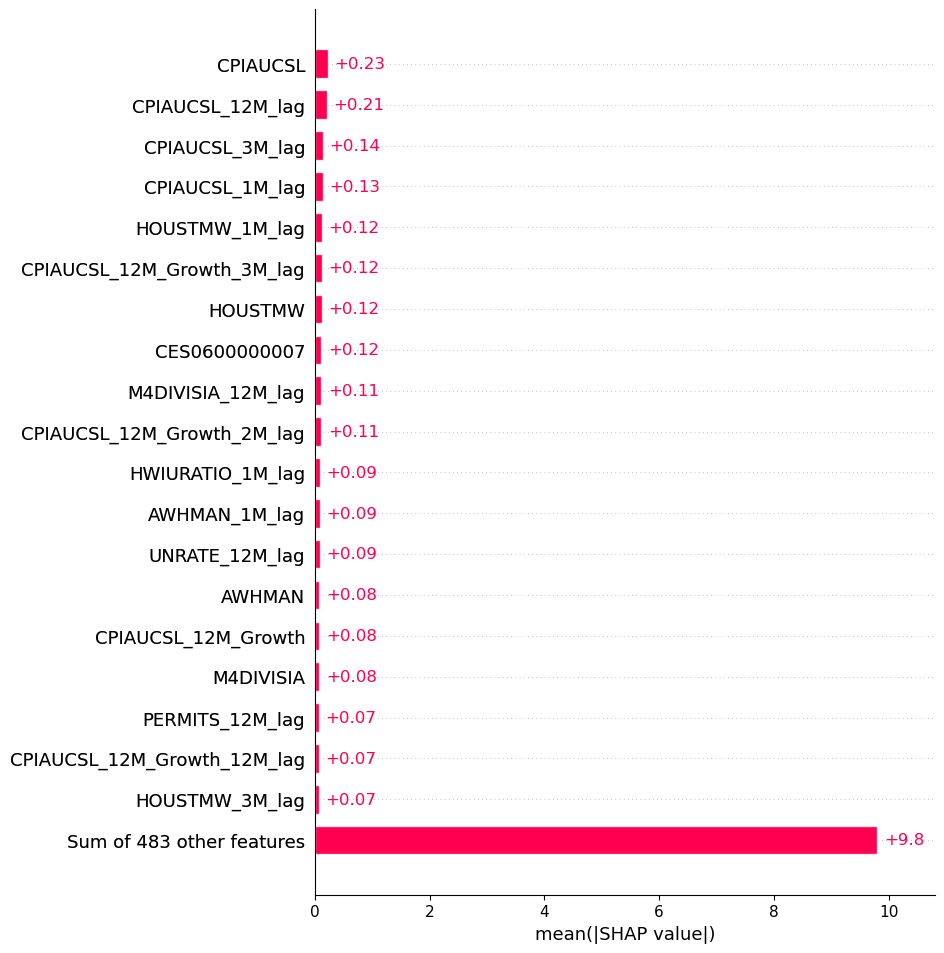

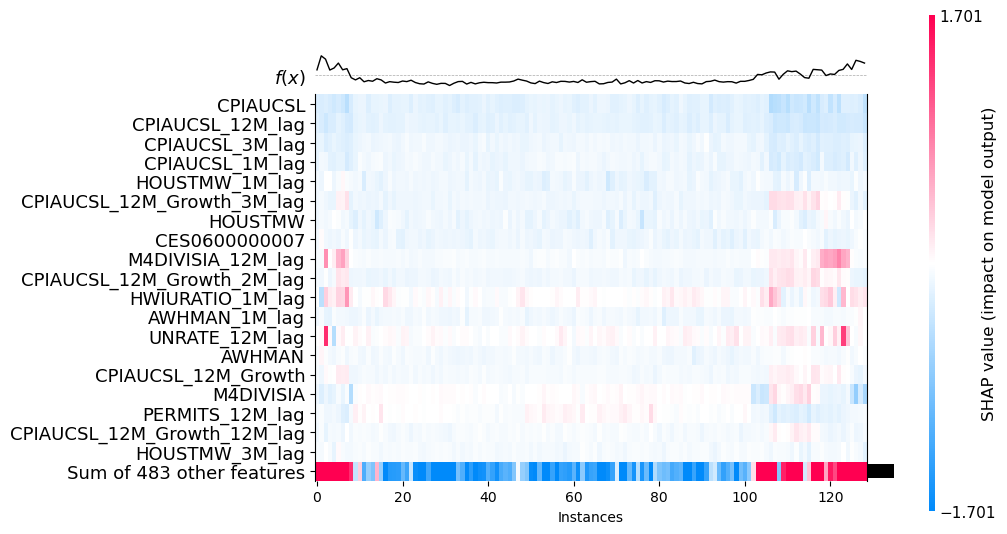

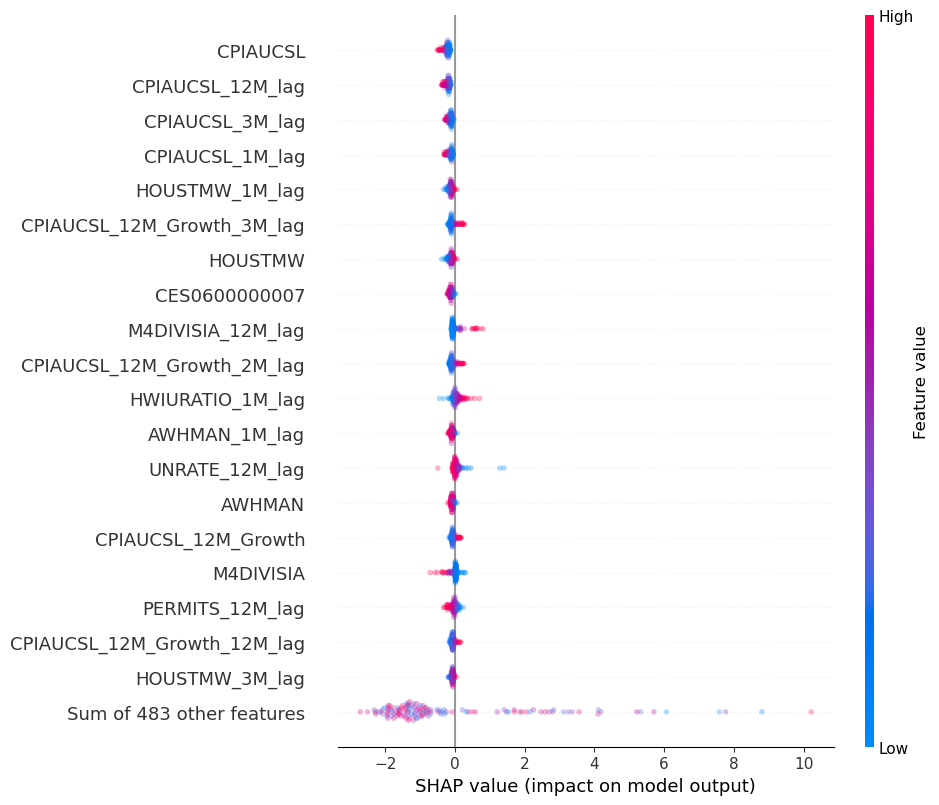

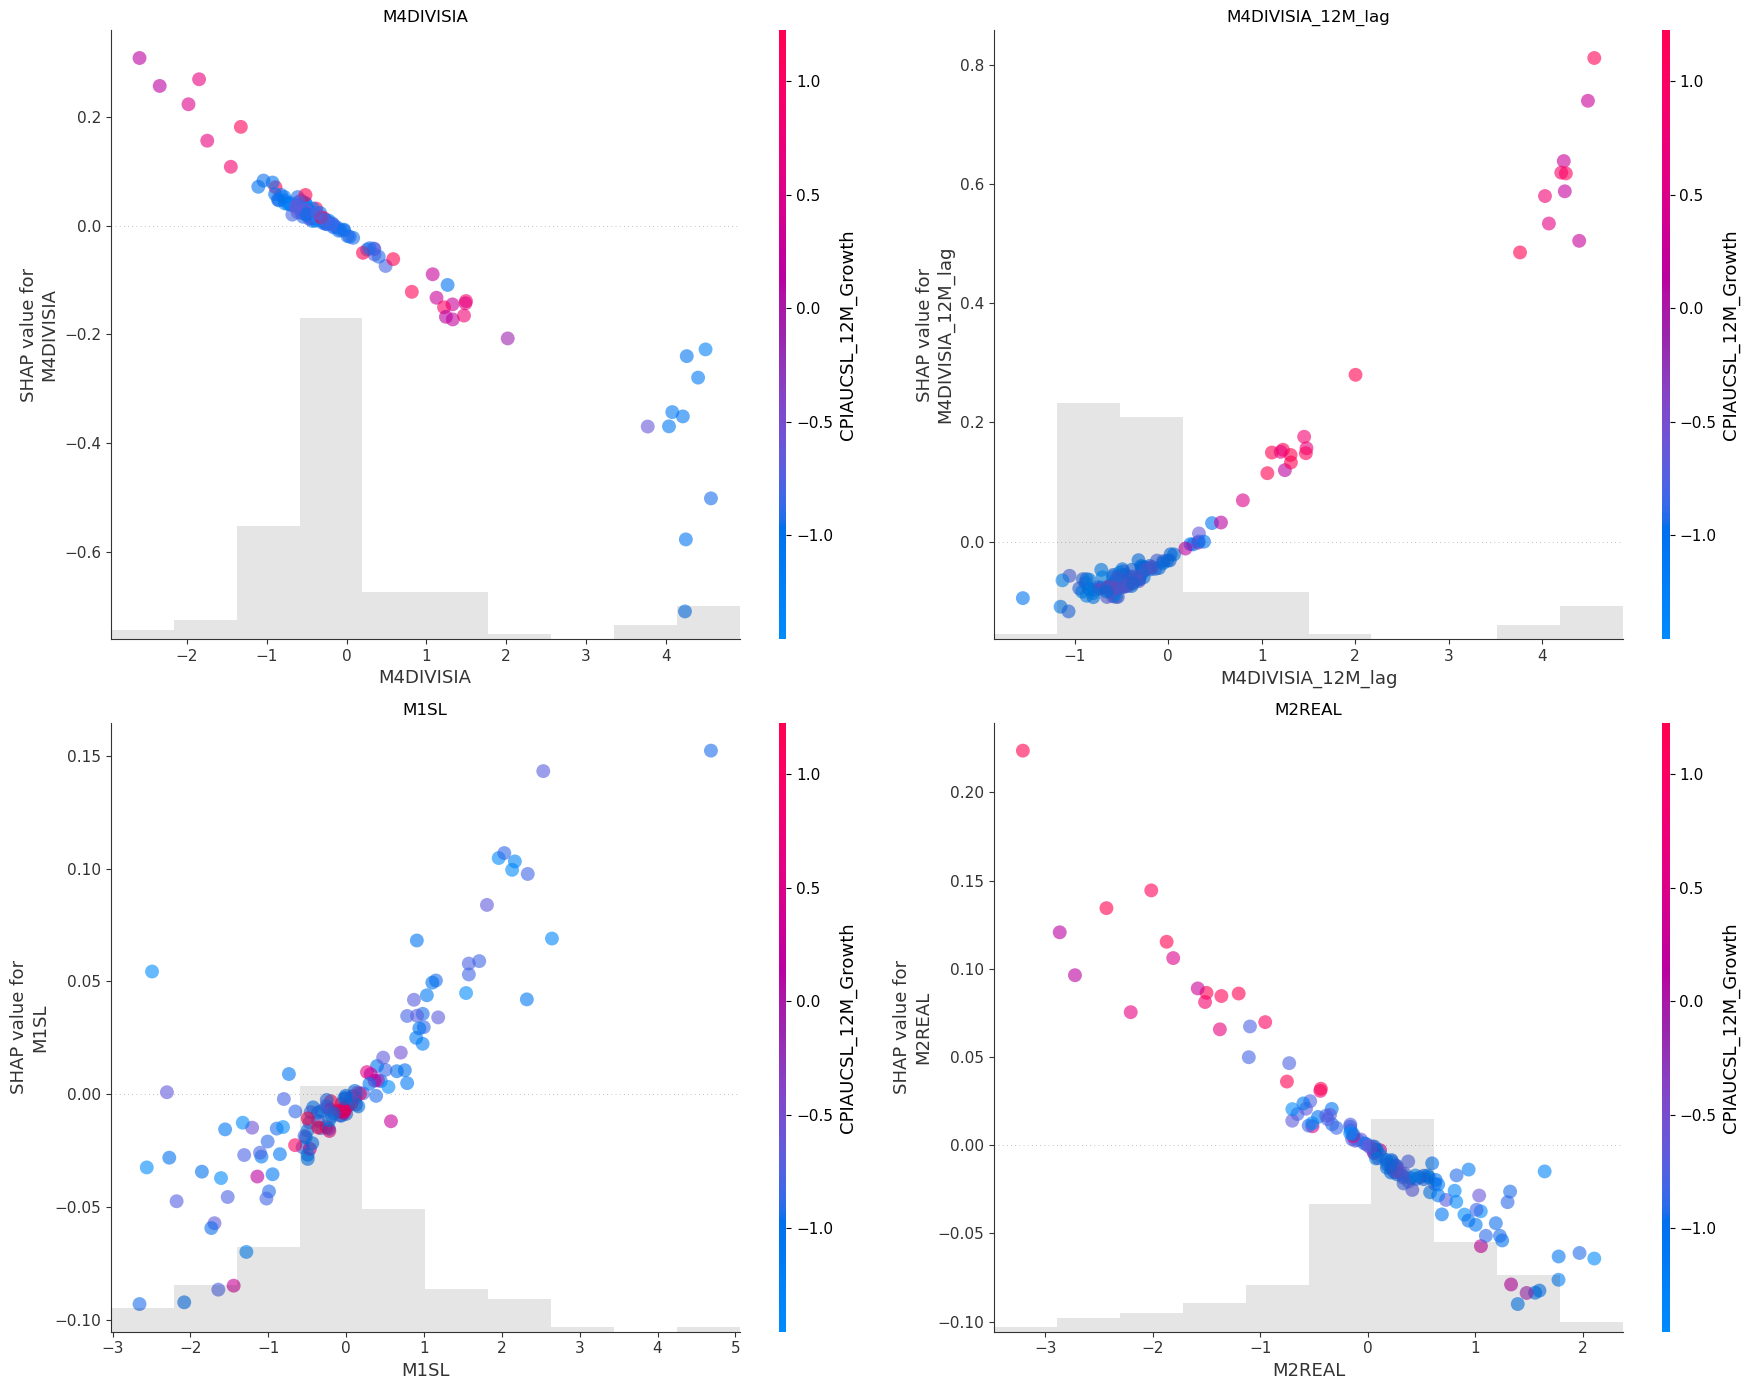

In [84]:
# Plotting SHAP values as bar plot
shap.plots.bar(best_shap_values, max_display=20)

# Plotting SHAP values as heatmap
shap.plots.heatmap(best_shap_values, max_display=20)

# Plotting SHAP values as beeswarm plot
shap.plots.beeswarm(best_shap_values, alpha=0.3, max_display=20)

# Plotting SHAP values as scatter plot for a specific feature
#shap.plots.scatter(best_shap_values[:, "M4DIVISIA"], color=best_shap_values[:, dep_var])

# Features to plot
features_to_plot = ["M4DIVISIA", "M4DIVISIA_12M_lag", "M1SL", "M2REAL"]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
axs = axs.flatten()

# Compute SHAP values for each feature and plot
for i, feature in enumerate(features_to_plot):
    # Plotting SHAP values as scatter plot for each feature
    scatter = shap.plots.scatter(best_shap_values[:, X_test_scaled.columns.get_loc(feature)], 
                                 color=best_shap_values[:, dep_var], 
                                 show=False, 
                                 ax=axs[i])
    # Adjust the plot's properties
    axs[i].collections[0].set_alpha(0.6)  # Set alpha transparency
    axs[i].collections[0].set_sizes([100])  # Set size of points, adjust the size as needed
    axs[i].set_title(feature)

# Adjust layout
plt.tight_layout()
plt.show()